# Fixed-Point Notebook


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from rfproto import sig_gen, plot

## Rounding Techniques

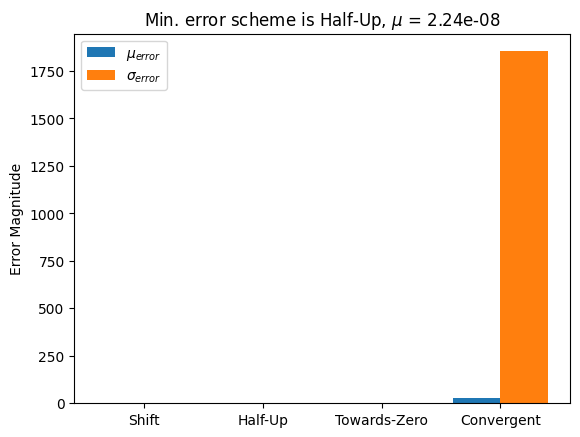

In [2]:
bitwidth = 16
N = bitwidth - 1
num_tests = 10000

MIN_VAL = -2**N
MAX_VAL = (2**N) - 1

shift_err = np.zeros(num_tests)
halfup_err = np.zeros(num_tests)
tozero_err = np.zeros(num_tests)
conv_err = np.zeros(num_tests)

def err_mag(x, ref):
    return (ref - (x / 2**N))

for i in range(num_tests):
    a = random.randint(MIN_VAL, MAX_VAL)
    b = random.randint(MIN_VAL, MAX_VAL)
    # full-width integer product, before any rounding/scaling scheme
    c = a * b

    # Floating-point comparison
    a_fp = 1.0 * a / 2**N
    b_fp = 1.0 * b / 2**N
    c_fp = a_fp * b_fp

    # Truncation: Simple bit shift >>
    c_shift = c >> N
    shift_err[i] = err_mag(c_shift, c_fp)

    # Round half up: basic scheme, similar to mulhrs AVX intrinisc
    # Truncate to N+1 bits, += 1, truncate down to final size >> 1
    # Better than raw truncation, but still some bias...
    c_halfup = ((c >> (N-1)) + 1) >> 1
    halfup_err[i] = err_mag(c_halfup, c_fp)

    # Round towards 0:
    c_to_0 = ((c >> (N-1)) + 1) >> 1 if (c < 0) else ((c >> (N-1)) - 1) >> 1
    tozero_err[i] = err_mag(c_to_0, c_fp)

    # Convergent rounding
    # default rounding mode used in IEEE 754 FP computing functions
    # from https://docs.xilinx.com/r/en-US/ug901-vivado-synthesis/Rounding-to-Even-Verilog
    multadd = c + 32768
    c_conv = multadd >> N
    if ((multadd & 0xFFFF) == 0): # pattern detect DSP48
        c_conv &= 0xFFFFFFFE
    #print(f"{c_shift} {c_conv}")
    conv_err[i] = err_mag(c_conv, c_fp)


schemes = [
    "Shift",
    "Half-Up",
    "Towards-Zero",
    "Convergent",
]
means = [
    abs(np.average(shift_err)),   
    abs(np.average(halfup_err)),
    abs(np.average(tozero_err)),
    abs(np.average(conv_err)),
]

stds = [
    np.std(shift_err),
    np.std(halfup_err),
    np.std(tozero_err),
    np.std(conv_err),
]

bar_width = 0.5
spacing = 1.25
n_sch = len(schemes)
x_means = np.linspace(0, spacing*(n_sch-1), n_sch)
x_stds  = [x + bar_width for x in x_means]
x_lbls  = [x + bar_width/2 for x in x_means]

idx_min = np.argmin(means)

plt.bar(x_means, means, width=bar_width, label = r'$\mu_{error}$')
plt.bar(x_stds, stds, width=bar_width, label = r'$\sigma_{error}$')
plt.xticks(x_lbls, schemes)
plt.ylabel('Error Magnitude')
plt.title(r'Min. error scheme is {0}, $\mu$ = {1:.2e}'.format(schemes[idx_min], means[idx_min]))
plt.legend()
plt.show()

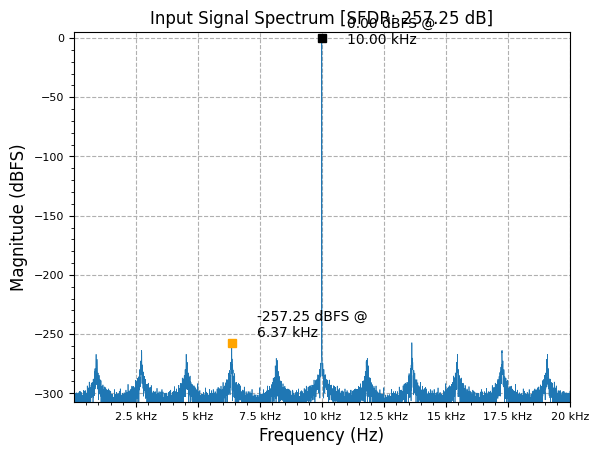

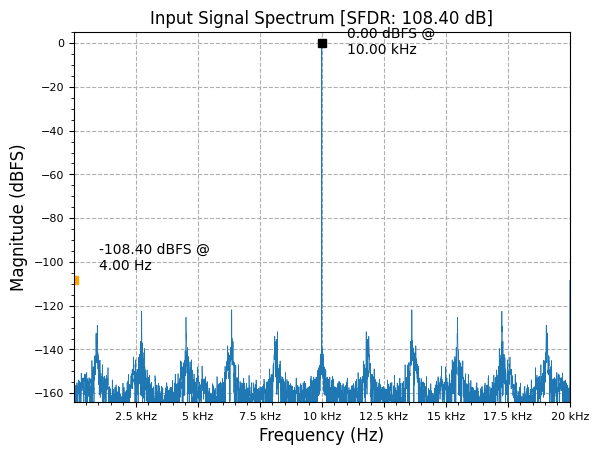

In [3]:
input_sig = sig_gen.cmplx_dt_sinusoid(2**20, 10000, 40000, 10000).real
floor_sig = np.floor(input_sig / 8)

plot.spec_an(input_sig, 40000, "Input Signal Spectrum", scale_noise=True, real=True, norm=True)
plot.spec_an(floor_sig, 40000, "Input Signal Spectrum", scale_noise=True, real=True, norm=True)
plt.show()

## References

* [Rounding to Nearest Integer - Wikipedia](https://en.wikipedia.org/wiki/Rounding#Rounding_to_the_nearest_integer)
* [Convergent Rounding LSB Correction Technique - Vivado UG901](https://docs.xilinx.com/r/en-US/ug901-vivado-synthesis/Convergent-Rounding-LSB-Correction-Technique)
* [Rounding Numbers without Adding a Bias](https://zipcpu.com/dsp/2017/07/22/rounding.html)